**Introduction to Machine Learning: Decision Tree**   
Topics Covered:   
1. CART
2. Selection Criteria
3. Iris Dataset Exploration
4. Decision Tree on Iris Data

In [257]:
import itertools  
import collections

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, KFold

**Introduction**   
A multitude of different decision tree algorithms exists, with ID3, C4.5 and CART being some of the more popular. In this discussion we will discuss CART, which is used by sklearn. We will also limit the discussion to classification trees in this example, even though regression trees exist. Additional detail can be read [here](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart).

**Selection Criterias: Entropy and Gini**   
For the CART algorithm in sklearn two different selection criterias exist. A term introduced as $p_{{\tau}k}$ is defined as the proportion of data points in region $\tau$ assigned to class k, where k = 1, ..., K. The variable $T$ refers to the tree or node choice.   
*Entropy:* $$Q_{\tau}(T) = -\sum_{k=1}^{K}p_{{\tau}k}log_{2}(p_{{\tau}k})$$ 
*Gini Index:* $$Q_{\tau}(T) = \sum_{k=1}^{K}p_{{\tau}k}(1-p_{{\tau}k})$$ To make these equations a little more relatable we are going to apply them across the iris dataset that was introduced in the logistic regression tutorial. To start the dataset will be imported and set up in a dataframe below.

In [40]:
flower = {
    0:'setosa',
    1:'versicolor',
    2:'virginica'}

iris = load_iris()
# feature vector
ft = pd.DataFrame(iris['data'], columns=iris['feature_names'])
# target vector, median value of housing area
tg = pd.DataFrame(iris['target'], columns=['target'])
# combine feature and target vector to make dataframe
df = pd.concat([ft, tg], axis=1, sort=False)
# add column with the actual flower species
df['species'] = df['target'].map(flower)

df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


**Iris Dataset Example:**   
For the iris dataset the regions, $\tau$ are effectively subsets of the features, normally defined as discrete values. Since the feature vectors are continuous comparison operators (less than, greater than) need to be applied. For our example a region would be all the flowers where the petal length is less than 2.45. This allows everything to be paired down to yes or no values. The classes, k, are the targets, shown as either setosa, versicolor, or viginica.   
**Find comparison operators:**   
The first step would be to select a few comparison criteria in the following example. Normally a computer program would find those, but we will break the problem down into the components. To accomplish this an inspection of the data needs to occur.  

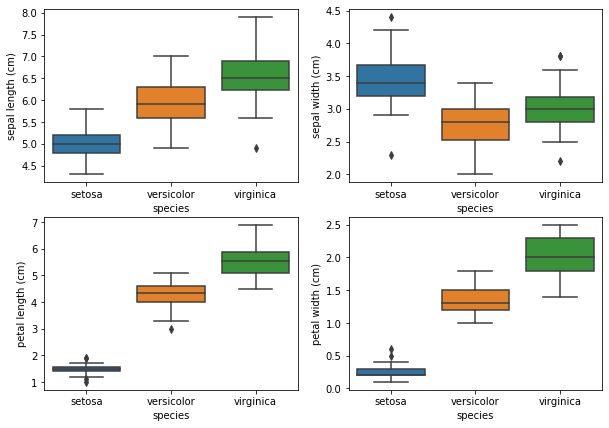

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

# flatten the axis array to easily iterate across it
axs = axs.flatten()

for key, ax in dict(zip(iris.feature_names, axs)).items():
    sns.boxplot(y = key, x = 'species', data = df, ax = ax)

**Setosa Classification**   
Right away it should be very apparent to the reader that the setosa flower has no overlap in data with versicolor or virginica flowers for petal length and petal width. *Side Note: When graphed it is apparent that petal length and petal width are not independent features, which means you should only really need one*. The first region of investigation will be flower with a petal length less than or equal to 2.45. This will be compared to an alternative region of flower with sepal length less than or equal to 5.5.

In [302]:
criteria = {
    'petal length (cm)':2.45,
    'sepal length (cm)':6
}

# make dictionary of zeros, this allows dataframe.count() to account
# for areas that have zero of an iris species
bdict = dict(zip(iris.target_names, np.zeros(len(iris.target_names))))

hdr = [['Feature', 'Less Than', 'Setosa', 'Versi', 'Virgi', 'Total']]
hdr.append(['---', '---', '---', '---', '---', '---'])
hdr.append(['Base', np.nan, 50.0, 50.0, 50.0, 150.0])
rslt = np.array([50, 50, 50, 150])

for key, val in criteria.items():
    dft = df[df[key].le(val)]
    adict = dict(dft.groupby('species').count().target)
    # done to account for counting zero classes in sub dataframe
    cdict = collections.defaultdict(int) # place to store values
    for kee, vul in itertools.chain(adict.items(), bdict.items()):
        # create dictionary that is combo of adict and bdict
        cdict[kee] += vul
    cdict = dict(cdict)
    raw = [key, val, cdict['setosa'], cdict['versicolor'], cdict['virginica'], sum(cdict.values())]
    rtmp = np.array([cdict['setosa'], cdict['versicolor'], cdict['virginica'], sum(cdict.values())])
    hdr.append(raw)
    
    rslt = np.vstack((rslt, rtmp))

smat = '{:17} | {:9} | {:6} | {:5} | {:5} | {:5}'
for r in hdr:
    print(smat.format(r[0], r[1], r[2], r[3], r[4], r[5]))

Feature           | Less Than | Setosa | Versi | Virgi | Total
---               | ---       | ---    | ---   | ---   | ---  
Base              |       nan |   50.0 |  50.0 |  50.0 | 150.0
petal length (cm) |      2.45 |   50.0 |   0.0 |   0.0 |  50.0
sepal length (cm) |         6 |   50.0 |  30.0 |   9.0 |  89.0


**Base Entropy and Gini Calculation**   
*Entropy base dataset:* 
$$-\frac{50}{150}log_{2}(\frac{50}{150})-\frac{50}{150}log_{2}(\frac{50}{150})-\frac{50}{150}log_{2}(\frac{50}{150}) = -1.585$$   
*Entropy Petal Length <= 2.45:*
$$-\frac{50}{50}log_{2}(\frac{50}{50})-\frac{0}{50}log_{2}(\frac{0}{50})-\frac{0}{50}log_{2}(\frac{0}{50}) = 0$$
*Entropy Sepal Length <= 6:*
$$-\frac{50}{89}log_{2}(\frac{50}{89})-\frac{30}{89}log_{2}(\frac{30}{89})-\frac{9}{89}log_{2}(\frac{9}{89}) = -1.33$$
*Gini base dataset:*   
$$\frac{50}{150}(1-\frac{50}{150})+\frac{50}{150}(1-\frac{50}{150})+\frac{50}{150}(1-\frac{50}{150}) = 0.66$$
*Gini Petal Length <= 2.45:* 
$$\frac{50}{50}(1-\frac{50}{50})+\frac{0}{50}(1-\frac{0}{50})+\frac{0}{50}(1-\frac{0}{50}) = 0$$
*Gini Sepal Length <= 6:* 
$$\frac{50}{89}(1-\frac{50}{89})+\frac{30}{89}(1-\frac{30}{89})+\frac{9}{89}(1-\frac{9}{89}) = 0.560$$

**Perform above calculation in python and numpy**

In [248]:
# calculate the probabilities
pmk = np.transpose(np.transpose(rslt[:,:-1])/rslt[:,-1])
# replace zero probability with super small to avoid log errors
pmk[pmk==0]=1e-6

entropy = []
gini = []

for row in pmk:
    ent = np.sum(row*np.log2(row))
    gin = np.sum(row*(1-row))
    entropy.append(ent)
    gini.append(gin)

tbl = [['Feature', 'Less Than', 'Entropy', 'Gini']]
tbl.append(['---', '---', '---', '---', '---', '---'])
tbl.append(['Base', np.nan, round(entropy[0], 3), round(gini[0], 3)])
i = 1
for key, val in criteria.items():
    tbl.append([key, val, round(entropy[i], 3), round(gini[i], 3)])
    i += 1

smat = '{:17} | {:9} | {:7} | {:5}'
for r in tbl:
    print(smat.format(r[0], r[1], r[2], r[3]))

Feature           | Less Than | Entropy | Gini 
---               | ---       | ---     | ---  
Base              |       nan |  -1.585 | 0.667
petal length (cm) |      2.45 |    -0.0 |   0.0
sepal length (cm) |         6 |   -1.33 | 0.561


**Information Gain**   
So the ultimate question should be, how does this help me (or the computer) make a decision on where to split the data? The idea is maximize the information gain from the split. $$IG = Q_{Parent} - Q_{Split}$$ Where IG is in the information gain and Q is the entropy. For our specific split assessment, the equations looks like the following: $$IG(pl<2.45) = -1.585 - (-0) = -1.585$$ $$IG(sl<6) = -1.585 - (-1.33) = -0.255$$ What this tells you is the information gain from splitting the parent (or base) dataset on petal length is a much better choice than sepal length.   
**Next Steps**   
For our example we only looked at splitting the parent dataset and two different options for what to split the data on. In an actual application we would want to assess many different options for splitting. The split dataset would be the new parent dataset and would require the process to be repeated. 

**Sklearn Decision Trees**   
The process will now be simplified by importing sklearn's decision tree solver. 

In [183]:
ft = [
    'sepal length (cm)',
    'sepal width (cm)',
    'petal length (cm)',
    'petal width (cm)']

tg = ['species']

X = df[ft].values
y = df[tg].values

clf = DecisionTreeClassifier(criterion='entropy')
dtree = clf.fit(X, y)

**Note on Plot Tree**   
Hopefully by the time this tutorial is being used sklearn has pushed out an update. It was identified in May 2019 that the word "entropy" was hardcoded into the plot_tree function. Even if GINI is used as the decision criteria, entropy will still be displayed, even though it is GINI. These issues can be see on github [here](https://github.com/scikit-learn/scikit-learn/issues/13944) and [here](https://github.com/scikit-learn/scikit-learn/pull/13947).

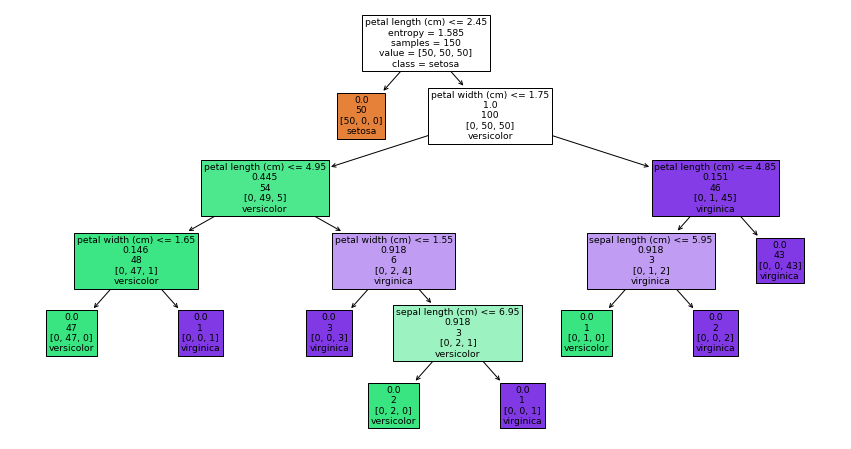

In [184]:
plt.figure(figsize=(15,8))
plot_tree(
    dtree,
    feature_names = iris.feature_names,
    class_names = iris.target_names,
    label='root',
    filled=True)
plt.show()

**Tree Results and Depth**   
As seen the longest path from the root (base data) to a leaf is five, referred to as the tree depth. Each box represents a dataset of values, with the bracketed numbers telling you how many of each class are inside. For example the top box represents the base dataset, 50, 50, 50, explains that there are 50 setosa, 50 versicolor and 50 virginica inside. As the tree progresses the different classes are catagorized into the respective bins of iris species. It should be relatively obvious that having a tree five deep may is a little overkill, in fact you may even say that four deep is overkill. Why? Look at how many values the model is trying to catagorize. Typically by the end of the tree you only have one-two "erronous" values trying to be properly binned. Though this works perfectly on your test data, how will it react to training data? This can be though as overfitting, where you make the model extremely complicated to try to match every single last value.

**Tune Tree Depth Parameter**   
The sklearn function GridSearchCV does an excellent job of fast model iteration to compare parameters. Below we are going to take the tree depth size from 2 to 5 to see how the model accuracy changes.

In [296]:
dpth_vals = np.arange(2, 6, 1)
split_num = 5
kfold = KFold(n_splits=split_num, random_state=42)
param_grid = dict(max_depth=dpth_vals)

dtree_grid = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold)

grid_result = dtree_grid.fit(X, y)

split_rslt = []
for i in range(split_num):
    split_rslt.append(grid_result.cv_results_['split'+str(i)+'_test_score'])   
split_rslt = np.asarray(split_rslt)

tree_rslt = {}
for i, d_val in enumerate(dpth_vals):
    tree_rslt.update({d_val:split_rslt[:,i]})

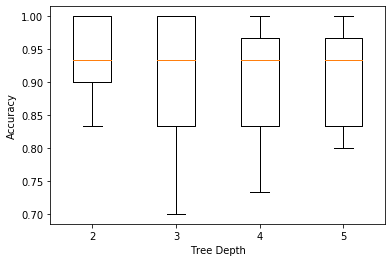

In [297]:
fig = plt.figure()    
# fig.suptitle('Comparing Size of Neighbors for KNN')
ax = fig.add_subplot(111)
plt.boxplot(tree_rslt.values())
ax.set_xticklabels(tree_rslt.keys())
ax.set_xlabel('Tree Depth')
ax.set_ylabel('Accuracy')
plt.show()

**Graph Interpretation**   
The original dataset only has 150 points, which is pretty low. Doing KFolds cross validation of five means each training set is 120 points and the test set is 30. Five splits is also is also borderline for being able to produce the boxplots that are shown above, ideally you would have 10 cross validation splits. The reason 10 splits wasn't done was becase that only leaves 15 points in the test set, which is quite low.   
The main point that the graph is showing is that reducing the overall tree depth doesn't have a huge impact on tree accuracy and performance. A tree will be trained below with a max depth of 3 and graphed to show the difference.

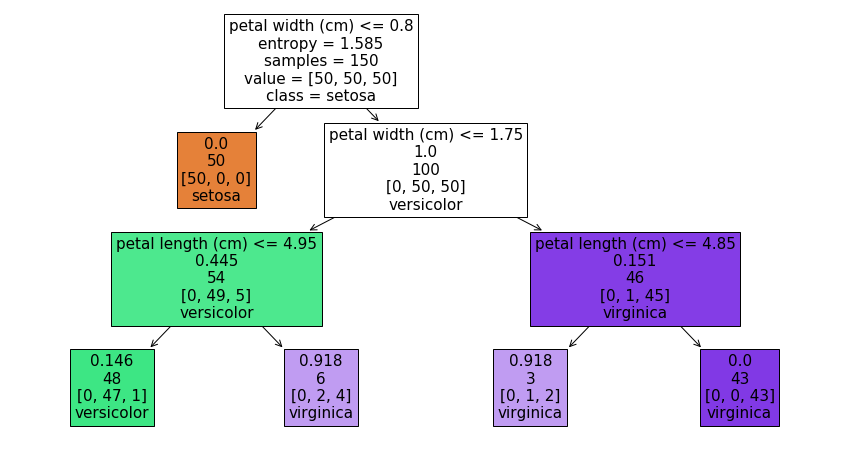

In [298]:
dclf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
dtree4 = dclf.fit(X, y)
plt.figure(figsize=(15,8))
plot_tree(
    dtree4,
    feature_names = iris.feature_names,
    class_names = iris.target_names,
    label='root',
    filled=True)
plt.show()

From looking at the above tree you can see with a tree depth of three a decent accuracy is met. A total of four observations are misclassified out of 150 or 2.5%. The important part to keep in mind is how the model will handle new data. Though the first tree may perfectly classify the training data this may not be a correct representation of total population. Though we don't explicitly cover bias/variance tradeoff in these tutorials, a tree that is five deep vs a tree that is three deep is a perfect example.

**Summary**   
In the tutorial a broad introduction to decision trees was introduced. The main decision criteria, entropy and gini, was introduced and a manual example was worked out for deciding split criteria. Afterwards sklearn was invoked to quickly create the tree and plot it. The question was briefly covered on how tree depth would affect model accuracy. Cross validation was performed on trees with varying depths, showing that the mean results stayed moderatly consistent. A final tree was made with depth of 3 to show the differences in trees and a comparison was made between bias/variance.

**Further Reading**   
The next steps the reader should take is to look at various ensemble methods. Models such as random forest, extra trees or gradient boosting for decision trees. These help automate some of the bias/variance tradeoff with methods such as bagging or boosting.   
**References**   
Decision Trees [Link](https://jameskle.com/writes/decision-trees)